In [53]:
import glob
import json
from typing import List

import pandas as pd
import seaborn as sns

In [54]:
ANNO_DATA_DIR: str = './annotated'
DATA_OUT_PATH: str = './dataset'
OUT_PATH: str = './figures'
RAW_DATA_DIR: str = './finished/main-gpt4' 

In [55]:
#raw_samples = [
#    json.load(open(file, 'r'))
#    for file in glob.glob(f'{ANNO_DATA_DIR}/.json')
#]
raw_samples = []
for filename in glob.glob(ANNO_DATA_DIR + '/*.json'):
    with open(filename, 'r') as f:
        file_data = json.load(f)
        for sample in file_data:
            raw_samples.append(sample)
len(raw_samples)


1038

In [56]:
dataset: pd.DataFrame = (
    pd.json_normalize(raw_samples)
    .set_index('id')    
    .replace({
        'mistralai/Mistral-7B-Instruct-v0.2': 'Mistral-7B'
    })
    .replace({
        'gpt-4-turbo-preview': 'GPT-4'
    })

)
#dataset.to_parquet(f'{DATA_OUT_PATH}.full.parquet')

In [ ]:
backgroundlist: List[str] = ["affluent-young-woman", "carpenter","environmental-activist","ex-convict", "hustler", "male-college-student", "office-worker", "pensioner", "phd-student", "privileged-woman", "retired-professor", "single-parent", "struggling-artist", "teenager", "unemployed", "wealthy-entrepreneur"]
personaslist: List[str] = ["neutral", "troll", "dystopian", "devilsadvocate", "know-it-all", "mediator", "educator", "karen", "misogynist", "misogynist-dense", "esoteric", "hippie-dense", "hippie", "supportive-saviour-dense", "influencer", "influencer-dense", "social-media-activist-dense", "social-media-activist", "anti", "hobby-expert-dense", "hobby-expert", "narcissist", "sceptic", "shy", "toxic-positive", "traditionalist"]
languagelist: List[str] = ["language-youth", "language-default", "language-old"]
political_viewlist: List[str] = ["conservative", "disengaged", "far-right", "progressive", "radical-left"]
real_tweets: List[str] = [
    ".\u2066@AOC\u2069 is it a \u201ccrime against humanity\u201d when \u2066@POTUS\u2069 secretly flies migrants into Westchester (the place you grew up)? The crime here is allowing the continued flow of illegal immigration, human trafficking and drugs. It has to stop!",
    "Biden\u2019s set on taking away your choice and forcing you to abide by his radical climate agenda. Un-American!",
    "Abortion is health care & should be between a woman & her doctor, not left to politicians like Yvette Herrell who would ban abortion without exceptions for rape, incest or the life of the mother. #NM02",
    "A high school debate team ignores the debate prompt and instead attacks white Christians...and then WINS THE DEBATE: \"We demand that white Christians be held accountable for America's original sin.\" This vile, anti-White racism is rewarded by so-called \"academics.\" We must stop it.",
    "The clean energy revolution is here and we’re going to power it with green union jobs.",
]
def find_language(persona):
    for language in languagelist:
        if language in persona:
            return language
    return None
def find_main_persona(persona):
    for p in personaslist:
        if p in persona:
            return p
    return None
def find_background(persona):
    for background in backgroundlist:
        if background in persona:
            return background
    return None
def find_political_view(persona):
    for political_view in political_viewlist:
        if political_view in persona:
            return political_view
    return None
def find_real_tweets(threads):
    for post in real_tweets:
        if post == threads:
            return True
    return False
dataset['background'] = dataset['persona'].apply(find_background)
dataset['main_persona'] = dataset['persona'].apply(find_main_persona)
dataset['language_prompt'] = dataset['persona'].apply(find_language)
dataset['political_view'] = dataset['persona'].apply(find_political_view)
dataset['real_tweet'] = dataset['threads'].apply(find_real_tweets)

dataset['background'].fillna('None', inplace=True)
dataset['language_prompt'].fillna('None', inplace=True)
dataset['political_view'].fillna('None', inplace=True)
dataset['main_persona'] = dataset['main_persona'].str.replace('-dense', '')
dataset[:1]
#open(f'{DATA_OUT_PATH}.full.json', 'w').write(json.dumps(raw_samples, indent=4, ensure_ascii=False))

In [ ]:

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Display the dataset
dataset[dataset['main_persona'] == 'hobby-expert']

/tmp/ipykernel_28502/2933873952.py:15: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(y='main_persona', x='annotation.authenticity', hue='model', data=avg, palette=colors, errorbar=None)


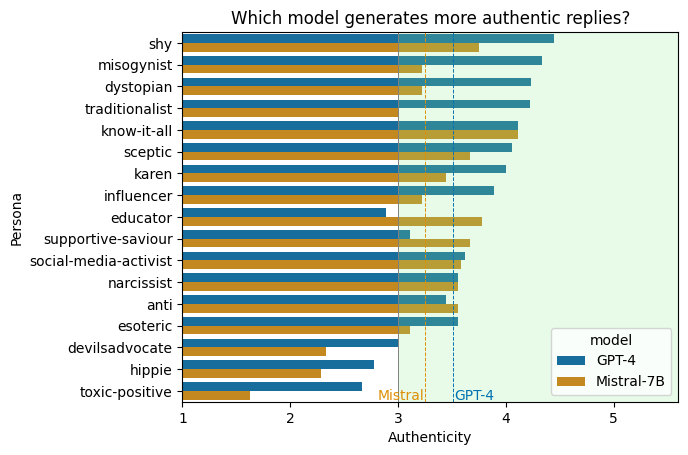

In [80]:
# comparison between mistral and GPT-4 
# compare authenticity between mistral and GPT-4 depending on main_persona
plot_name = '05_authenticity_mistralvGPT4_per_persona_bar_chart'

mistral_samples = dataset[dataset['model'] == 'Mistral-7B']
gpt4_samples = dataset[(dataset['model'] == 'GPT-4') & (dataset['persona'].isin(mistral_samples['persona']))]
mistral_gpt4_samples = pd.concat([mistral_samples, gpt4_samples])
avg = mistral_gpt4_samples.groupby(['model', 'main_persona'])['annotation.authenticity'].mean().reset_index()
#model_avg = dataset.groupby('model')['annotation.authenticity'].mean().reset_index()
#print(model_avg)
avg = avg.sort_values(by='annotation.authenticity', ascending=False)


colors = sns.color_palette('colorblind')
ax = sns.barplot(y='main_persona', x='annotation.authenticity', hue='model', data=avg, palette=colors, errorbar=None)
ax.set_xlim(1, 5.6)  # Set x-axis limit to 5
ax.set_title('Which model generates more authentic replies?')
ax.set_ylabel('Persona')
ax.set_xlabel('Authenticity')

ax.axvline(x=3.506, color=colors[0], linestyle='--', linewidth=0.7)
ax.text(3.52, 15.9, 'GPT-4', color=colors[0], ha='left', va='top')
ax.axvline(x=3.25, color=colors[1], linestyle='--', linewidth=0.7)
ax.text(3.24, 15.9, 'Mistral', color=colors[1], ha='right', va='top')
# Add background for x values of 3 and higher
ax.axvline(x=3.0, color='grey', linestyle='-', linewidth=0.7)
ax.axvspan(3, 5.6, facecolor='lightgreen', alpha=0.2)
ax.set_xticks(range(1, 6))
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

In [21]:
#

display('Base statistics grouped by languages.') 
(
    dataset
    .groupby('model', observed=False)
    .describe(percentiles=[])
    .loc[:, (slice(None), ['mean', 'std'])]
    .T
    #.reindex(columns=LANG_ORDER)
)
display('Sample size per persona:')
dataset.groupby('main_persona').size()


'Base statistics grouped by languages.'

'Sample size per persona:'

main_persona
anti                     63
devilsadvocate           63
dystopian                63
educator                 36
esoteric                 36
hippie                   36
hobby-expert             27
influencer               36
karen                    36
know-it-all              45
mediator                 27
misogynist               90
narcissist               36
neutral                  63
sceptic                  63
shy                      54
social-media-activist    45
supportive-saviour       27
toxic-positive           36
traditionalist           54
troll                    48
dtype: int64

In [ ]:
#authenticity bar chart per persona
"""
colors = sns.color_palette('Set2')

ax = (
    dataset
    .groupby('main_persona', observed=False)
    .describe(percentiles=[])
    .loc[:, ('annotation.authenticity', ['mean'])]
    .T
    .plot(kind='bar', width=5, color=colors)  
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add dashed line at value 3.0 on y-axis
ax.axhline(y=3.0, color=(0.2, 0.2, 0.2), linestyle='--')
"""

"\ncolors = sns.color_palette('Set2')\n\nax = (\n    dataset\n    .groupby('main_persona', observed=False)\n    .describe(percentiles=[])\n    .loc[:, ('annotation.authenticity', ['mean'])]\n    .T\n    .plot(kind='bar', width=5, color=colors)  \n)\n\nax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')\nax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')\n\n# Add dashed line at value 3.0 on y-axis\nax.axhline(y=3.0, color=(0.2, 0.2, 0.2), linestyle='--')\n"

3.522837706511176


/tmp/ipykernel_28502/3189510044.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='annotation.authenticity', y='main_persona', data=avg_authenticity, palette=colors)
/tmp/ipykernel_28502/3189510044.py:8: UserWarning: 
The palette list has fewer values (10) than needed (21) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='annotation.authenticity', y='main_persona', data=avg_authenticity, palette=colors)


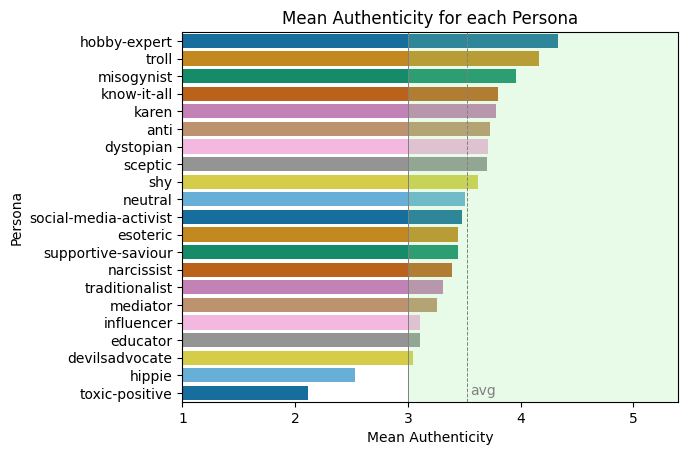

In [16]:

# Calculate the average of annotation.authenticity per main_persona
plot_name = '01_authenticity_per_persona_bar_chart'
avg_authenticity = dataset.groupby('main_persona')['annotation.authenticity'].mean().reset_index()
avg_authenticity = avg_authenticity.sort_values(by='annotation.authenticity', ascending=False)
model_avg = dataset['annotation.authenticity'].mean()
print(model_avg)
colors = sns.color_palette('colorblind')
ax = sns.barplot(x='annotation.authenticity', y='main_persona', data=avg_authenticity, palette=colors)
ax.set_xlim(1, 5.4)  # Set x-axis limit to 5
ax.set_xlabel('Mean Authenticity')
ax.set_ylabel('Persona')
ax.set_title('Mean Authenticity for each Persona')

# Add dashed line at authenticity 3.0
ax.axvline(x=3.523, color='grey', linestyle='--', linewidth=0.7)
ax.text(3.55, 19.5, 'avg', color='grey', ha='left', va='top')
# Add background for x values of 3 and higher
ax.axvline(x=3.0, color='grey', linestyle='-', linewidth=0.7)
ax.axvspan(3, 5.5, facecolor='lightgreen', alpha=0.2)
ax.set_xticks(range(1, 6))

ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

3.7937743190661477


/tmp/ipykernel_28502/1045773286.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='annotation.tone', y='main_persona', data=avg, palette=colors)
/tmp/ipykernel_28502/1045773286.py:8: UserWarning: 
The palette list has fewer values (10) than needed (21) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='annotation.tone', y='main_persona', data=avg, palette=colors)


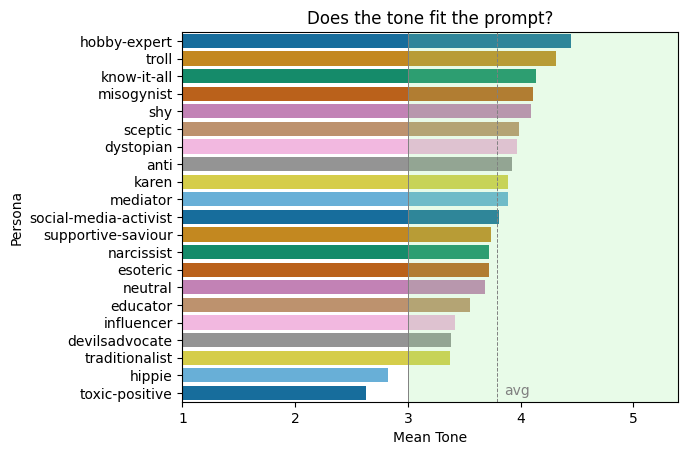

In [17]:

# Calculate the average of annotation.tone per main_persona
plot_name = '04_anno.tone_per_persona_bar_chart'
avg = dataset.groupby('main_persona')['annotation.tone'].mean().reset_index()
avg = avg.sort_values(by='annotation.tone', ascending=False)
avg_tone = dataset['annotation.tone'].mean()
print(avg_tone)
colors = sns.color_palette('colorblind')
ax = sns.barplot(x='annotation.tone', y='main_persona', data=avg, palette=colors)
ax.set_xlim(1, 5.4)  # Set x-axis limit to 5
ax.set_xlabel('Mean Tone')
ax.set_ylabel('Persona')
ax.set_title('Does the tone fit the prompt?')

ax.axvline(x=3.794, color='grey', linestyle='--', linewidth=0.7)
ax.text(3.85, 19.5, 'avg', color='grey', ha='left', va='top')
# Add background for x values of 3 and higher
ax.axvline(x=3.0, color='grey', linestyle='-', linewidth=0.7)
ax.axvspan(3, 5.5, facecolor='lightgreen', alpha=0.2)
ax.set_xticks(range(1, 6))
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

4.140419947506562


/tmp/ipykernel_28502/1643757071.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='annotation.politics', y='main_persona', data=avg, palette=colors)
/tmp/ipykernel_28502/1643757071.py:8: UserWarning: 
The palette list has fewer values (10) than needed (21) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='annotation.politics', y='main_persona', data=avg, palette=colors)


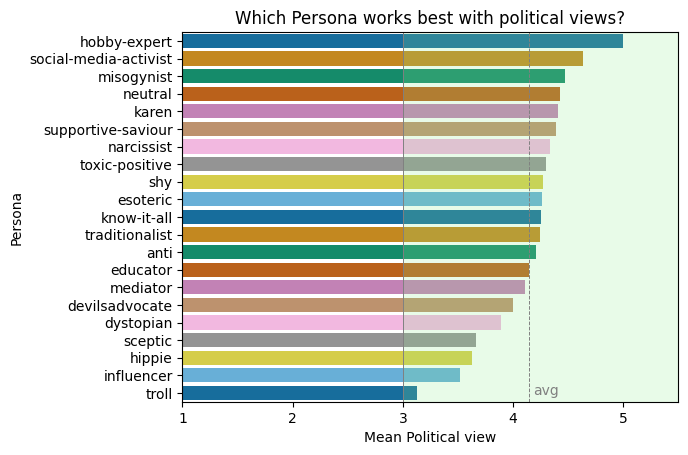

In [18]:
# Calculate the average of annotation.politics per main_persona
plot_name = '02_anno.politics_per_persona_bar_chart'
avg = dataset.groupby('main_persona')['annotation.politics'].mean().reset_index()
avg = avg.sort_values(by='annotation.politics', ascending=False)
avg_politics = dataset['annotation.politics'].mean()
print(avg_politics)
colors = sns.color_palette('colorblind')
ax = sns.barplot(x='annotation.politics', y='main_persona', data=avg, palette=colors)
ax.set_xlim(1, 5.5)  # Set x-axis limit to 5
ax.set_xlabel('Mean Political view')
ax.set_ylabel('Persona')
ax.set_title('Which Persona works best with political views?')


ax.axvline(x=4.14, color='grey', linestyle='--', linewidth=0.7)
ax.text(4.18, 19.5, 'avg', color='grey', ha='left', va='top')
# Add background for x values of 3 and higher
ax.axvline(x=3.0, color='grey', linestyle='-', linewidth=0.7)
ax.axvspan(3, 5.5, facecolor='lightgreen', alpha=0.2)
ax.set_xticks(range(1, 6))
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

3.859086491739553


/tmp/ipykernel_28502/3408301519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='annotation.persona', y='main_persona', data=avg, palette=colors)
/tmp/ipykernel_28502/3408301519.py:8: UserWarning: 
The palette list has fewer values (10) than needed (21) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='annotation.persona', y='main_persona', data=avg, palette=colors)


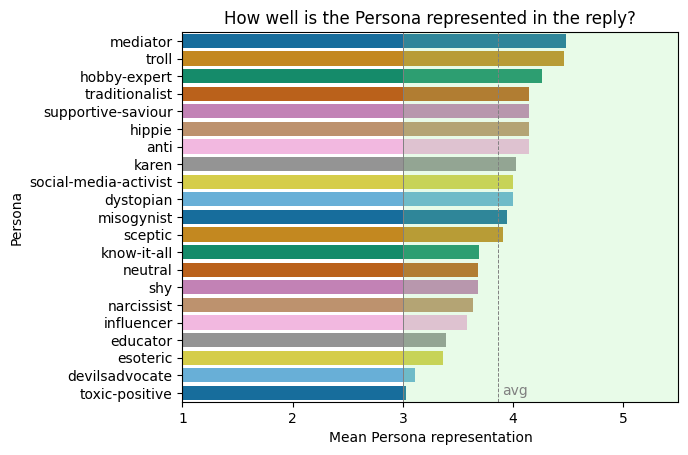

In [19]:

# Calculate the average of annotation.persona per main_persona
plot_name = '03_anno.persona_per_persona_bar_chart'
avg = dataset.groupby('main_persona')['annotation.persona'].mean().reset_index()
avg = avg.sort_values(by='annotation.persona', ascending=False)
avg_pers = dataset['annotation.persona'].mean()
print(avg_pers)
colors = sns.color_palette('colorblind')
ax = sns.barplot(x='annotation.persona', y='main_persona', data=avg, palette=colors)
ax.set_xlim(1, 5.5)  # Set x-axis limit to 5
ax.set_xlabel('Mean Persona representation')
ax.set_ylabel('Persona')
ax.set_title('How well is the Persona represented in the reply?')

ax.axvline(x=3.859, color='grey', linestyle='--', linewidth=0.7)
ax.text(3.9, 19.5, 'avg', color='grey', ha='left', va='top')
# Add background for x values of 3 and higher
ax.axvline(x=3.0, color='grey', linestyle='-', linewidth=0.7)
ax.axvspan(3, 5.5, facecolor='lightgreen', alpha=0.2)
ax.set_xticks(range(1, 6))
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

In [ ]:

plot_name = 'displot'
selected_dataset = dataset[dataset['main_persona'].isin(['troll', 'traditionalist', 'know-it-all'])]
ax = sns.displot(
    selected_dataset, 
    x="annotation.authenticity", 
    col="main_persona", 
    row="real_tweet", 
    hue="language_prompt", 
    kde=True,
    #row_order=LANG_ORDER,
)

#ax.savefig(f'{OUT_PATH}/dist.persona.png', format="png", bbox_inches="tight") 

/tmp/ipykernel_28502/3949098336.py:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(y='language_prompt', x='annotation.authenticity', hue='real_tweet', data=dataset, palette=colors, errorbar=None)


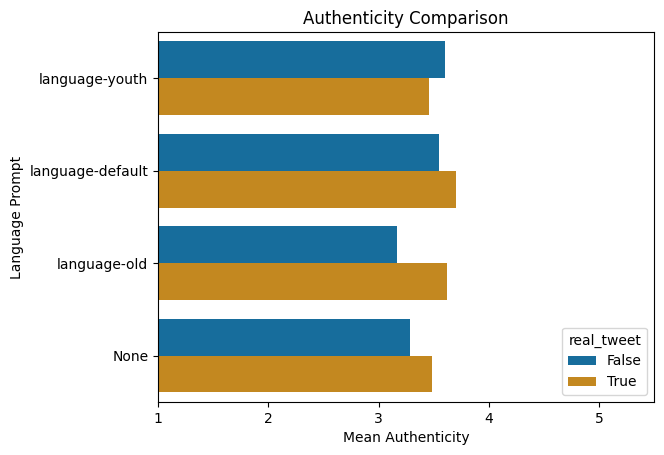

In [22]:
# compare authenticity between real and generated tweets depending on language prompt
plot_name = 'authenticity_realvfake_per_language_bar_chart'
colors = sns.color_palette('colorblind')
ax = sns.barplot(y='language_prompt', x='annotation.authenticity', hue='real_tweet', data=dataset, palette=colors, errorbar=None)
ax.set_xlim(1, 5.5)  # Set x-axis limit to 5
ax.set_title('Authenticity Comparison')
ax.set_ylabel('Language Prompt')
ax.set_xlabel('Mean Authenticity')
sns.move_legend(ax, "lower right")
ax.set_xticks(range(1, 6))
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

/tmp/ipykernel_28502/3623715559.py:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(y='language_prompt', x='annotation.tone', hue='real_tweet', data=dataset, palette=colors, errorbar=None)


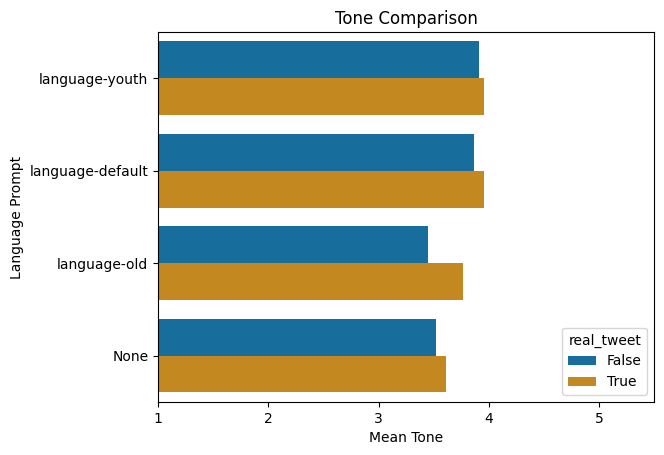

In [21]:
# compare tone between real and fake tweets depending on language prompt
plot_name = 'tone_realvfake_per_language_bar_chart'
colors = sns.color_palette('colorblind')
ax = sns.barplot(y='language_prompt', x='annotation.tone', hue='real_tweet', data=dataset, palette=colors, errorbar=None)
ax.set_xlim(1, 5.5)  # Set x-axis limit to 5
ax.set_title('Tone Comparison')
ax.set_xlabel('Mean Tone')
ax.set_ylabel('Language Prompt')
sns.move_legend(ax, "lower right")
ax.set_xticks(range(1, 6))
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

with_language_prompt
False    3.392361
True     3.573549
Name: annotation.authenticity, dtype: float64


/tmp/ipykernel_28502/2865337359.py:11: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(y='main_persona', x='annotation.authenticity', hue='with_language_prompt', data=dataset, palette=colors, errorbar=None)


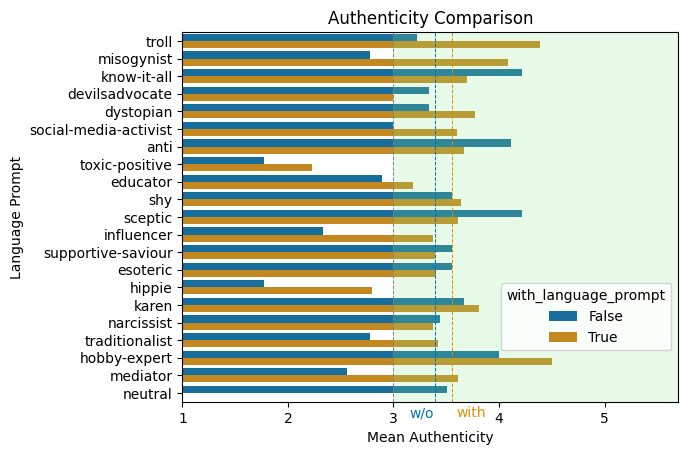

In [66]:
# compare tone between language prompt and no language prompt depending on language prompt
plot_name = '06_authenticity_per_persona_language_yesvno_bar_chart'
colors = sns.color_palette('colorblind')

# Filter the dataset to include only the rows with language prompts
dataset['with_language_prompt'] = dataset['language_prompt'] != "None"
avg_auth_binary = dataset.groupby(['with_language_prompt'])['annotation.authenticity'].mean()
#avg_auth_binary = avg_auth_binary.sort_values(by='annotation.authenticity', ascending=False)
print(avg_auth_binary)
# Plot the tone comparison without error bars
ax = sns.barplot(y='main_persona', x='annotation.authenticity', hue='with_language_prompt', data=dataset, palette=colors, errorbar=None)
ax.set_xlim(1, 5.7)  # Set x-axis limit to 5
ax.set_title('Authenticity Comparison')
ax.set_xlabel('Mean Authenticity')
ax.set_ylabel('Language Prompt')

ax.axvline(x=3.3924, color=colors[0], linestyle='--', linewidth=0.7)
ax.text(3.38, 20.75, 'w/o', color=colors[0], ha='right', va='top')
ax.axvline(x=3.55735, color=colors[1], linestyle='--', linewidth=0.7)
ax.text(3.6, 20.75, 'with', color=colors[1], ha='left', va='top')
# Add background for x values of 3 and higher
ax.axvline(x=3.0, color='grey', linestyle='--', linewidth=0.7)
ax.axvspan(3, 5.7, facecolor='lightgreen', alpha=0.2)

sns.move_legend(ax, "lower right", bbox_to_anchor=(1.0, 0.12))
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

SyntaxError: invalid syntax (4049715127.py, line 22)

/tmp/ipykernel_28502/4125949458.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(y='main_persona', x='annotation.tone', hue='with_language_prompt', data=dataset, palette=colors, order=avg_tone['main_persona'], errorbar=None)


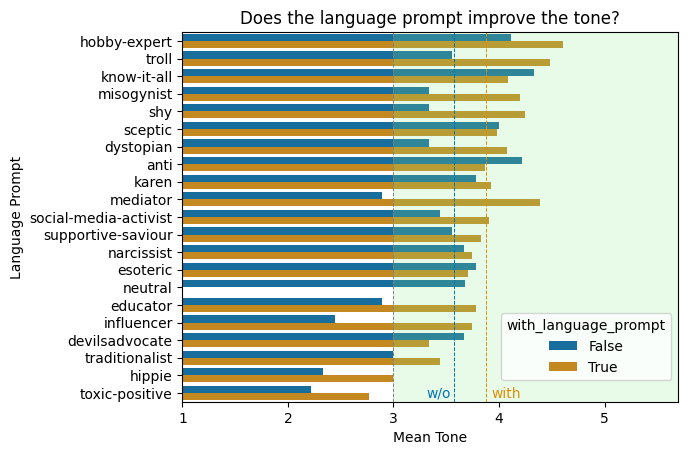

In [74]:
# compare tone between language prompt and no language prompt depending on language prompt
plot_name = '07_tone_per_persona_language_yesvno_bar_chart'
colors = sns.color_palette('colorblind')

# Filter the dataset to include only the rows with language prompts and exclude the "neutral" persona
dataset['with_language_prompt'] = dataset['language_prompt'] != "None"

# Calculate the average tone per persona
avg_tone = dataset.groupby('main_persona')['annotation.tone'].mean().reset_index()
avg_tone = avg_tone.sort_values(by='annotation.tone', ascending=False)
#print(avg_tone)
# Plot the tone comparison without error bars
ax = sns.barplot(y='main_persona', x='annotation.tone', hue='with_language_prompt', data=dataset, palette=colors, order=avg_tone['main_persona'], errorbar=None)
ax.set_xlim(1, 5.7)  # Set x-axis limit to 5
ax.set_title('Does the language prompt improve the tone?')
ax.set_xlabel('Mean Tone')
ax.set_ylabel('Language Prompt')

ax.axvline(x=3.573, color=colors[0], linestyle='--', linewidth=0.7)
ax.text(3.54, 19.65, 'w/o', color=colors[0], ha='right', va='top')
ax.axvline(x=3.88, color=colors[1], linestyle='--', linewidth=0.7)
ax.text(3.93, 19.65, 'with', color=colors[1], ha='left', va='top')
# Add background for x values of 3 and higher
ax.axvline(x=3.0, color='grey', linestyle='--', linewidth=0.7)
ax.axvspan(3, 5.9, facecolor='lightgreen', alpha=0.2)

sns.move_legend(ax, "lower right", bbox_to_anchor=(1.0, 0.04))
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

/tmp/ipykernel_28502/2096905281.py:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(y='political_view', x='annotation.politics', hue='real_tweet', data=dataset[dataset['political_view'] != 'None'], palette=colors, errorbar=None)


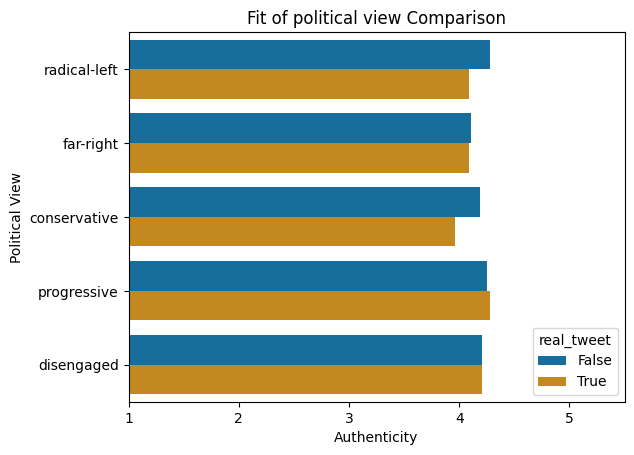

In [24]:
# compare fit of political opinion between real and generated tweets depending on political view
plot_name = 'political_view_fit_realvfake_bar_chart'
colors = sns.color_palette('colorblind')
ax = sns.barplot(y='political_view', x='annotation.politics', hue='real_tweet', data=dataset[dataset['political_view'] != 'None'], palette=colors, errorbar=None)
ax.set_xlim(1, 5.5)  # Set x-axis limit to 5
ax.set_title('Fit of political view Comparison')
ax.set_ylabel('Political View')
ax.set_xlabel('Authenticity')
sns.move_legend(ax, "lower right")
ax.set_xticks(range(1, 6))
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

/tmp/ipykernel_28502/1554847722.py:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(x='annotation.authenticity', y='political_view', hue='real_tweet', data=dataset[dataset['political_view'] != 'None'], palette=colors, errorbar=None)


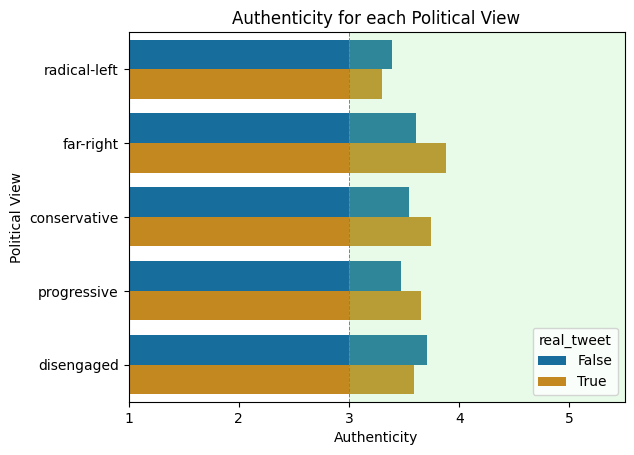

In [79]:
# compare authenticity of political opinion between real and generated tweets depending on political view
plot_name = '08_authenticity_realvfake_per_political_view_bar_chart'
colors = sns.color_palette('colorblind')
ax = sns.barplot(x='annotation.authenticity', y='political_view', hue='real_tweet', data=dataset[dataset['political_view'] != 'None'], palette=colors, errorbar=None)
ax.set_xlim(1, 5.5)  # Set x-axis limit to 5
ax.set_xticks(range(1, 6))
ax.set_title('Authenticity for each Political View')
ax.set_ylabel('Political View')
ax.set_xlabel('Authenticity')
# Add background for x values of 3 and higher
ax.axvline(x=3.0, color='grey', linestyle='--', linewidth=0.7)
ax.axvspan(3, 5.9, facecolor='lightgreen', alpha=0.2)
sns.move_legend(ax, "lower right")
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")

In [ ]:
# real vs fake tweets
"""
plot_name = 'realvfake_per_persona_bar_chart'
sample_personas = ["troll", "devilsadvocate", "know-it-all"]
ax = sns.violinplot(
    data=dataset,
    x="sample_personas",
    y="annotation.authenticity",
    hue="real_tweet",
    inner="quart",
    split=True,
    #order=[TWEET_ORDER],
    cut=0
)
sns.move_legend(ax, "lower right")
ax.get_figure().savefig(f'{OUT_PATH}/{plot_name}.png', format="png", bbox_inches="tight")
"""

'\nplot_name = \'realvfake_per_persona_bar_chart\'\nsample_personas = ["troll", "devilsadvocate", "know-it-all"]\nax = sns.violinplot(\n    data=dataset,\n    x="sample_personas",\n    y="annotation.authenticity",\n    hue="real_tweet",\n    inner="quart",\n    split=True,\n    #order=[TWEET_ORDER],\n    cut=0\n)\nsns.move_legend(ax, "lower right")\nax.get_figure().savefig(f\'{OUT_PATH}/{plot_name}.png\', format="png", bbox_inches="tight")\n'